In [231]:
import numpy as np
import scipy as sp
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt

from exp_family import GaussianDistribution
from projectors import BoxProjector, EigenBoxProjector, CoordProjector
from optimizers import projected_gradient

In [232]:
np.random.seed(124)
obj = lambda x: x[0] * sp.stats.multivariate_normal.pdf(x, mean=[4, 4], cov=np.diag([1, 1]))
projector = CoordProjector(BoxProjector(-10, 10), EigenBoxProjector(1, 15))

In [233]:
thetas, estimations = projected_gradient(obj, GaussianDistribution, projector, 
                                         1e-5, (np.array([0, 0]), np.eye(2)), n_iters=10 ** 5)

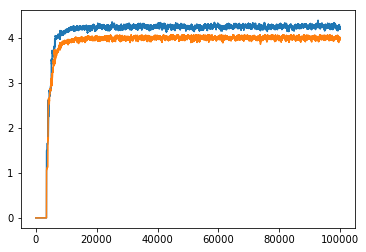

In [234]:
# plot mu history, should converge to 4,4
mu = [np.linalg.pinv(x[1]).dot(x[0]) for x in thetas]
plt.plot(mu)

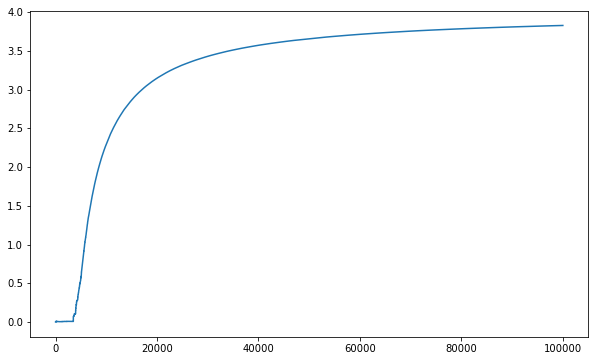

In [235]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(estimations))

# ================

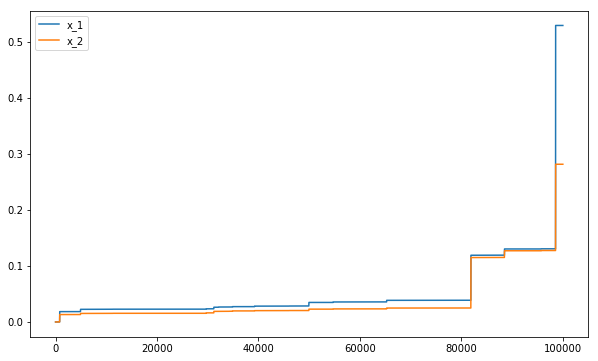

In [58]:
plt.figure(figsize=(10, 6))
plt.plot([x[0][0] for x in thetas])
plt.plot([x[0][1] for x in thetas])

plt.legend(['x_1', 'x_2'])

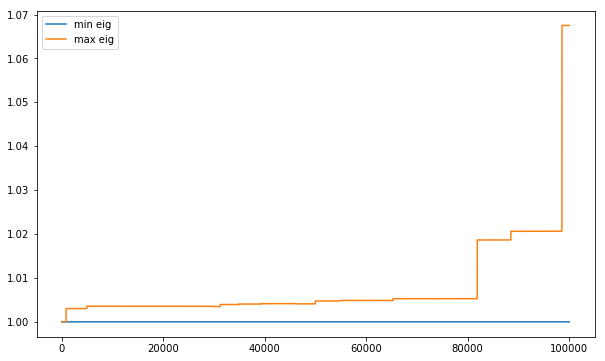

In [59]:
plt.figure(figsize=(10, 6))

eigs = [np.linalg.eigvals(x[1]) for x in thetas]

plt.plot([min(x) for x in eigs])
plt.plot([max(x) for x in eigs])

plt.legend(['min eig', 'max eig'])